In [1]:

import numpy as np
import pandas as pd
import pickle  
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


from lightgbm import LGBMRegressor



from sklearn.metrics import mean_squared_error as mse, r2_score as r2


from IPython.display import Image

In [2]:
raw_dataset_path = r'datasets/realestatepriceprediction/train.csv'
prepared_ds_path = r'datasets/realestatepriceprediction/train_prep.csv'

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Data fields<br>
* **Id** - идентификационный номер квартиры<br>
* **DistrictId** - идентификационный номер района<br>
* **Rooms** - количество комнат<br>
* **Square** - площадь<br>
* **LifeSquare** - жилая площадь<br>
* **KitchenSquare** - площадь кухни<br>
* **Floor** - этаж<br>
* **HouseFloor** - количество этажей в доме<br>
* **HouseYear** - год постройки дома<br>
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности<br>
* **Social_1, Social_2, Social_3** - социальные показатели местности<br>
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья<br>
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров<br>
* **Price** - цена квартиры

In [4]:
df_train = pd.read_csv(raw_dataset_path)

In [5]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [7]:
df_train.set_index('Id', inplace=True)

In [8]:
df_train.head(15)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250
12915,59,3.0,80.384476,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.453125
14549,154,2.0,62.254112,37.160378,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.218750
11993,74,2.0,80.312927,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156250
5172,1,2.0,64.511436,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.796875


In [9]:
target = df_train['Price']

In [10]:
target.head()

Id
14038    184966.937500
15053    300009.437500
4765     220925.906250
5809     175616.234375
10783    150226.531250
Name: Price, dtype: float32

<AxesSubplot:xlabel='Price', ylabel='Density'>

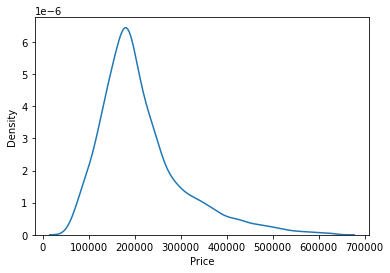

In [11]:
sns.kdeplot(target)

In [12]:
df_train = df_train.drop(columns='Price')

In [13]:
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     7887 non-null   float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   5202 non-null   float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-nul

In [15]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300
std,43.587592,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


### Выбросы


* HouseYear > 2021
* Floor > HouseFloor
* Floor = 0, HouseFloor = 0
* Square < 3
* KitchenSquare > Sqaure
* LifeSquare > Square
* Rooms = 0
* Square/Rooms = RoomsPerSquare < 3

#### штош...

Самое просто это год. И каких-то данных, косвенно влияющих на год постройки у нас нет, поэтому просто пихнем в выборсы текущий год

In [16]:
df_train.loc[df_train['HouseYear'] > 2021, 'HouseYear'] = 2021

In [17]:
df_train.describe()['HouseYear']

count    10000.000000
mean      1984.872600
std         18.416734
min       1910.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2021.000000
Name: HouseYear, dtype: float64

### Floor

In [18]:
df_train.loc[df_train['HouseFloor'] == 0]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
11993,74,2.0,80.312927,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
6641,54,3.0,118.907608,NaN,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B
4378,27,3.0,106.958870,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A
9371,23,2.0,60.503250,NaN,0.0,16,0.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B
10521,38,3.0,104.211395,106.340401,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12302,30,1.0,46.072914,48.307846,0.0,4,0.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
9384,59,3.0,98.607330,NaN,0.0,14,0.0,1977,0.019509,B,B,37,7687,11,176.0,5,5,B
11441,62,2.0,71.985336,72.453232,0.0,5,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [19]:
df_train.loc[(df_train['HouseFloor'] < df_train['Floor']) & df_train['Floor'] != 0]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10953,27,1.0,53.769096,52.408028,1.0,5,4.0,1977,7.215758e-02,B,B,2,629,1,NaN,0,0,A
11935,27,2.0,64.711838,NaN,1.0,15,1.0,1977,2.114012e-01,B,B,9,1892,0,NaN,0,1,B
4378,27,3.0,106.958870,0.641822,0.0,17,0.0,2018,7.215758e-02,B,B,2,629,1,NaN,0,0,A
10103,94,1.0,35.280895,23.354176,6.0,11,9.0,1971,2.827977e-01,B,B,33,8667,2,NaN,0,6,B
8443,57,2.0,45.964890,29.141212,5.0,7,5.0,1963,1.332153e-01,B,B,49,11395,3,1406.0,3,4,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,27,3.0,84.250710,4.187885,1.0,15,1.0,2016,7.215758e-02,B,B,2,629,1,NaN,0,0,A
4660,158,2.0,63.131653,41.867912,8.0,9,8.0,1939,4.203159e-02,B,B,37,6856,84,1940.0,2,5,B
16050,67,2.0,58.629681,36.330029,9.0,19,17.0,1989,1.004557e-01,B,B,43,7227,0,NaN,1,6,A


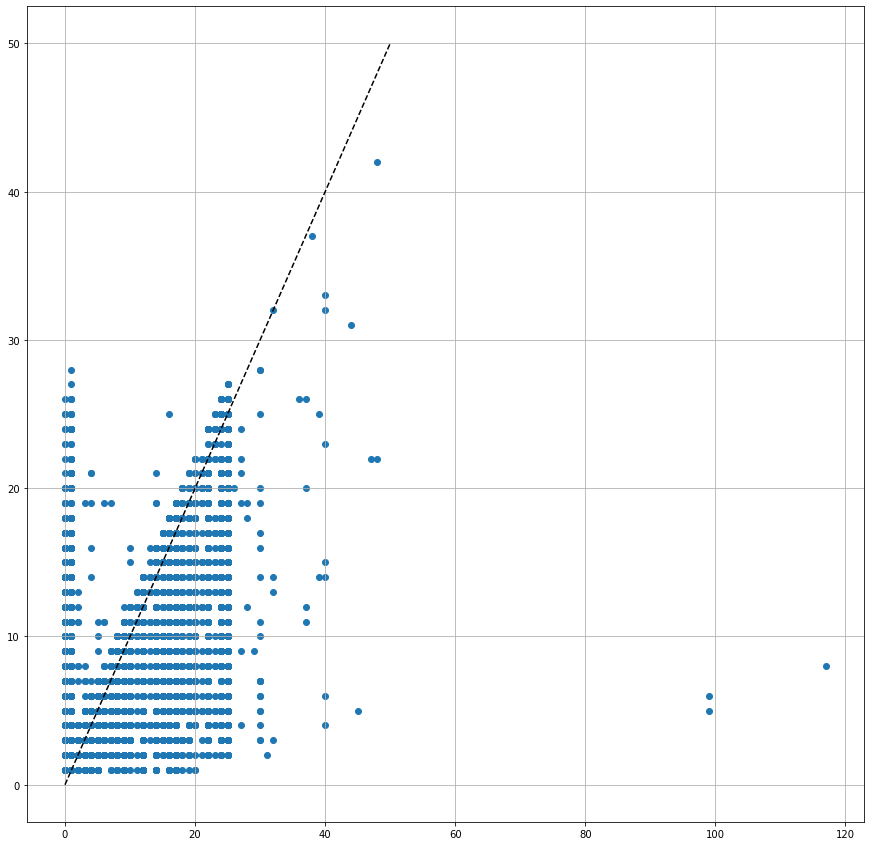

In [20]:
plt.figure(figsize=(15,15))
plt.plot([0, 50], [0, 50], linestyle='--', color='black')
plt.grid()
plt.scatter(df_train['HouseFloor'], df_train['Floor'])
plt.show()

#### обработаем HouseFloor

In [21]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train.loc[df_train['HouseFloor'] == 0, 'Floor']

In [22]:
df_train['FloorPos'] = df_train['Floor'] / df_train['HouseFloor']

In [23]:
floor_pos_med = df_train.loc[df_train['FloorPos'] <= 1, 'FloorPos'].median()
floor_pos_med

0.6000000238418579

<AxesSubplot:ylabel='Density'>

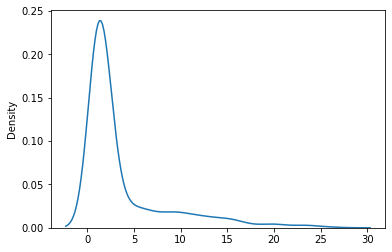

In [24]:
sns.kdeplot(df_train.loc[df_train['FloorPos'] > 1, 'Floor'] - df_train.loc[df_train['FloorPos'] > 1, 'HouseFloor'])

In [25]:
floor_pos_board = 5

<AxesSubplot:xlabel='FloorPos', ylabel='Density'>

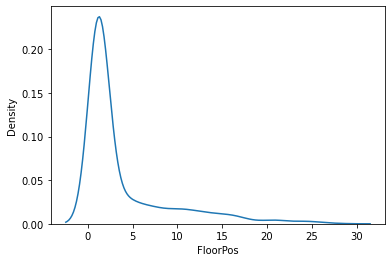

In [26]:
sns.kdeplot(df_train.loc[df_train['FloorPos'] > 1, 'FloorPos'])

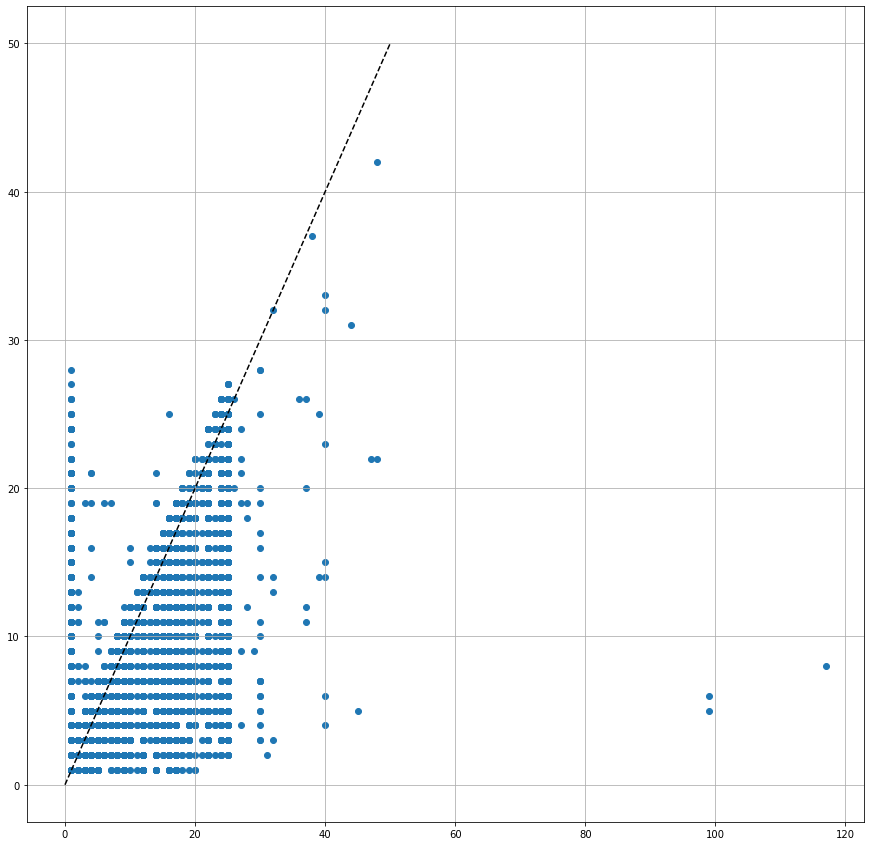

In [27]:
plt.figure(figsize=(15,15))
plt.plot([0, 50], [0, 50], linestyle='--', color='black')
plt.grid()
plt.scatter(df_train['HouseFloor'], df_train['Floor'])
plt.show()

In [28]:
df_train.loc[(df_train['FloorPos'] < 5) & (df_train['FloorPos'] > 1), 'FloorPos']

Id
10953    1.250000
2119     1.200000
6486     1.200000
10103    1.222222
8443     1.400000
           ...   
5071     1.066667
2237     1.222222
4145     1.083333
11553    1.058824
77       1.200000
Name: FloorPos, Length: 1178, dtype: float32

In [29]:
df_train.loc[df_train['FloorPos'] > 1, 'Floor'] - df_train.loc[df_train['FloorPos'] > 1, 'HouseFloor']

Id
10953     1.0
2119      1.0
11935    14.0
6486      1.0
10103     2.0
         ... 
2237      2.0
16159     9.0
4145      2.0
11553     1.0
77        1.0
Length: 1556, dtype: float32

In [30]:
must_be_housefloor = df_train.loc[df_train['FloorPos'] > 1, 'Floor']
df_train.loc[df_train['FloorPos'] > 1, 'Floor'] = df_train.loc[df_train['FloorPos'] > 1, 'HouseFloor']
df_train.loc[df_train['FloorPos'] > 1, 'HouseFloor'] = must_be_housefloor

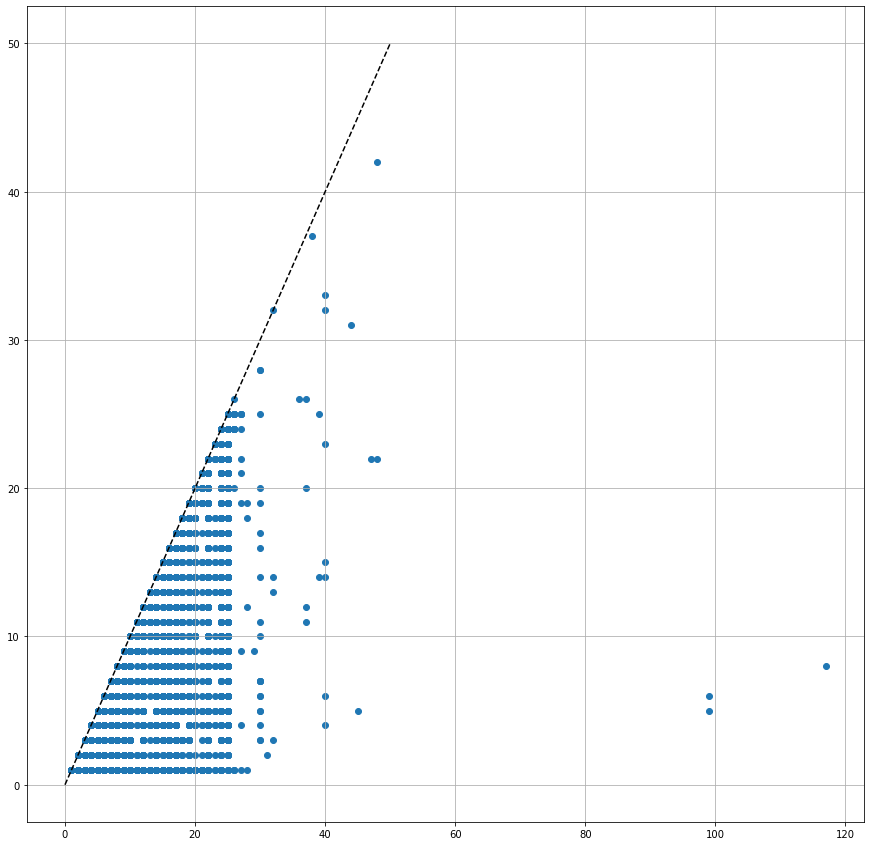

In [31]:
plt.figure(figsize=(15,15))
plt.plot([0, 50], [0, 50], linestyle='--', color='black')
plt.grid()
plt.scatter(df_train['HouseFloor'], df_train['Floor'])
plt.show()

In [32]:
df_train['FloorPos'] = df_train['Floor'] / df_train['HouseFloor']

In [33]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,FloorPos
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315712,37.199596,6.273300,7.943200,13.435700,1984.872600,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,0.606983
std,43.587592,0.839523,21.058718,86.241112,28.561113,5.228094,6.094035,18.416734,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,0.284851
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.035714
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,0.352941
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,0.642857
75%,75.000000,2.000000,65.900627,45.128803,9.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,0.875000
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2021.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000


* Square < 3
* KitchenSquare > Sqaure
* LifeSquare > Square
* Rooms = 0
* Square/Rooms = RoomsPerSquare < 3
* Rooms > 5

In [35]:
df_train['SquarePerRoom'] = df_train['Square'] / df_train['Rooms']
df_train['LifeSqRatio'] = df_train['LifeSquare'] / df_train['Square']
df_train['KitcheSqRatio'] = df_train['KitchenSquare'] / df_train['Square']

In [36]:
square_feats = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'SquarePerRoom', 'LifeSqRatio', 'KitcheSqRatio']

In [41]:
df_train[square_feats].describe()

,Rooms,Square,LifeSquare,KitchenSquare,SquarePerRoom,LifeSqRatio,KitcheSqRatio
count,10000.000000,10000.000000,7887.000000,10000.000000,1.000000e+04,7887.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,inf,0.665886,0.123297
std,0.839523,21.058718,86.241112,28.561113,NaN,1.072916,0.749377
min,0.000000,1.136859,0.370619,0.000000,1.136859e+00,0.006001,0.000000
25%,1.000000,41.774879,22.769833,1.000000,2.559167e+01,0.556235,0.022591
50%,2.000000,52.513309,32.781261,6.000000,3.083162e+01,0.617527,0.120688
75%,2.000000,65.900627,45.128803,9.000000,3.901167e+01,0.696916,0.165121
max,19.000000,641.065186,7480.592285,2014.000000,inf,91.567970,61.034805


In [44]:
df_train.loc[df_train['Square'] < 5, square_feats]

,Rooms,Square,LifeSquare,KitchenSquare,SquarePerRoom,LifeSqRatio,KitcheSqRatio
Id,,,,,,,
11526,1.0,4.633498,1.969969,1.0,4.633498,0.425158,0.215820
10202,1.0,2.596351,4.604943,1.0,2.596351,1.773621,0.385156
10527,1.0,4.380726,40.805836,1.0,4.380726,9.314857,0.228273
3224,0.0,2.377248,0.873147,0.0,inf,0.367293,0.000000
4504,3.0,4.390331,5.610772,1.0,1.463444,1.277984,0.227773
14786,1.0,1.136859,4.525736,1.0,1.136859,3.980913,0.879617
13265,3.0,4.823679,79.767967,0.0,1.607893,16.536747,0.000000
15744,1.0,1.988943,2.642219,1.0,1.988943,1.328454,0.502780
6782,1.0,2.954309,5.257278,1.0,2.954309,1.779529,0.338489


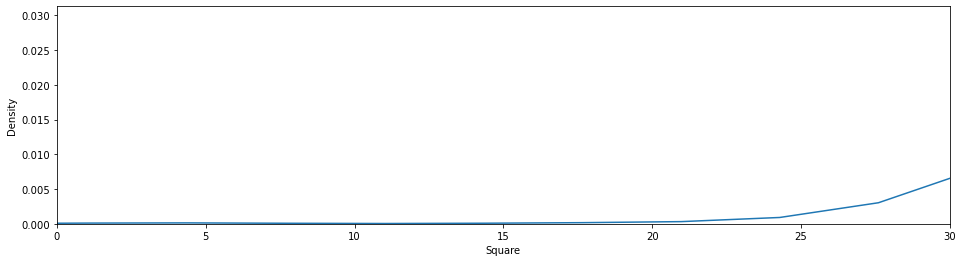

In [51]:
plt.figure(figsize=(16,4))

sns.kdeplot(df_train['Square'])
plt.xlim(0, 30)
plt.show()

In [53]:
df_train.loc[df_train['Square'] < 5, 'Square'] = 5

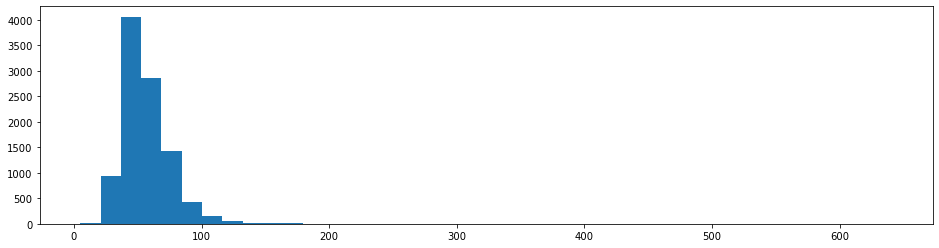

In [59]:
plt.figure(figsize=(16,4))

plt.hist(df_train['Square'], bins=40)

plt.show()

In [60]:
df_train.loc[df_train['KitchenSquare'] > df_train['Square'], square_feats]

,Rooms,Square,LifeSquare,KitchenSquare,SquarePerRoom,LifeSqRatio,KitcheSqRatio
Id,,,,,,,
14656,1.0,47.100719,46.447960,2014.0,47.100719,0.986141,42.759430
13703,1.0,38.071693,19.723547,73.0,38.071693,0.518063,1.917435
6569,1.0,38.220257,18.716856,84.0,38.220257,0.489710,2.197788
14679,1.0,32.276665,19.278395,1970.0,32.276665,0.597286,61.034805


In [66]:
kitchen_med = df_train.loc[df_train['KitcheSqRatio'] < 1, 'KitcheSqRatio'].median()

In [73]:
df_train.loc[df_train['KitcheSqRatio'] > 1, 'KitchenSquare'] =\
                                                     df_train.loc[df_train['KitcheSqRatio'] > 1, 'Square'] * kitchen_med

In [75]:
df_train.loc[df_train['KitcheSqRatio'] > 1, square_feats]

,Rooms,Square,LifeSquare,KitchenSquare,SquarePerRoom,LifeSqRatio,KitcheSqRatio
Id,,,,,,,
14656,1.0,47.100719,46.447960,5.683482,47.100719,0.986141,42.759430
13703,1.0,38.071693,19.723547,4.593980,38.071693,0.518063,1.917435
6569,1.0,38.220257,18.716856,4.611907,38.220257,0.489710,2.197788
14679,1.0,32.276665,19.278395,3.894714,32.276665,0.597286,61.034805


In [76]:
df_train.loc[df_train['Rooms'] == 0, square_feats]

,Rooms,Square,LifeSquare,KitchenSquare,SquarePerRoom,LifeSqRatio,KitcheSqRatio
Id,,,,,,,
12638,0.0,138.427689,136.215500,0.0,inf,0.984019,0.000000
7917,0.0,212.932358,211.231125,0.0,inf,0.992010,0.000000
7317,0.0,41.790882,NaN,0.0,inf,NaN,0.000000
770,0.0,49.483501,NaN,0.0,inf,NaN,0.000000
456,0.0,81.491447,NaN,0.0,inf,NaN,0.000000
3224,0.0,5.000000,0.873147,0.0,inf,0.367293,0.000000
3159,0.0,38.697117,19.345131,9.0,inf,0.499911,0.232575
9443,0.0,87.762619,85.125473,0.0,inf,0.969951,0.000000


In [79]:
room_sq_med = df_train.loc[df_train['Rooms'] != 0, 'SquarePerRoom'].median()
room_sq_med

30.82149887084961

In [80]:
df_train.loc[df_train['Rooms'] == 0, 'Rooms'] = (df_train.loc[df_train['Rooms'] == 0, 'Square'] // room_sq_med) + 1

In [82]:
df_train.loc[df_train['SquarePerRoom'] > 2000, square_feats]

,Rooms,Square,LifeSquare,KitchenSquare,SquarePerRoom,LifeSqRatio,KitcheSqRatio
Id,,,,,,,
12638,5.0,138.427689,136.215500,0.0,inf,0.984019,0.000000
7917,7.0,212.932358,211.231125,0.0,inf,0.992010,0.000000
7317,2.0,41.790882,NaN,0.0,inf,NaN,0.000000
770,2.0,49.483501,NaN,0.0,inf,NaN,0.000000
456,3.0,81.491447,NaN,0.0,inf,NaN,0.000000
3224,1.0,5.000000,0.873147,0.0,inf,0.367293,0.000000
3159,2.0,38.697117,19.345131,9.0,inf,0.499911,0.232575
9443,3.0,87.762619,85.125473,0.0,inf,0.969951,0.000000


In [83]:
df_train['SquarePerRoom'] = df_train['Square'] / df_train['Rooms']

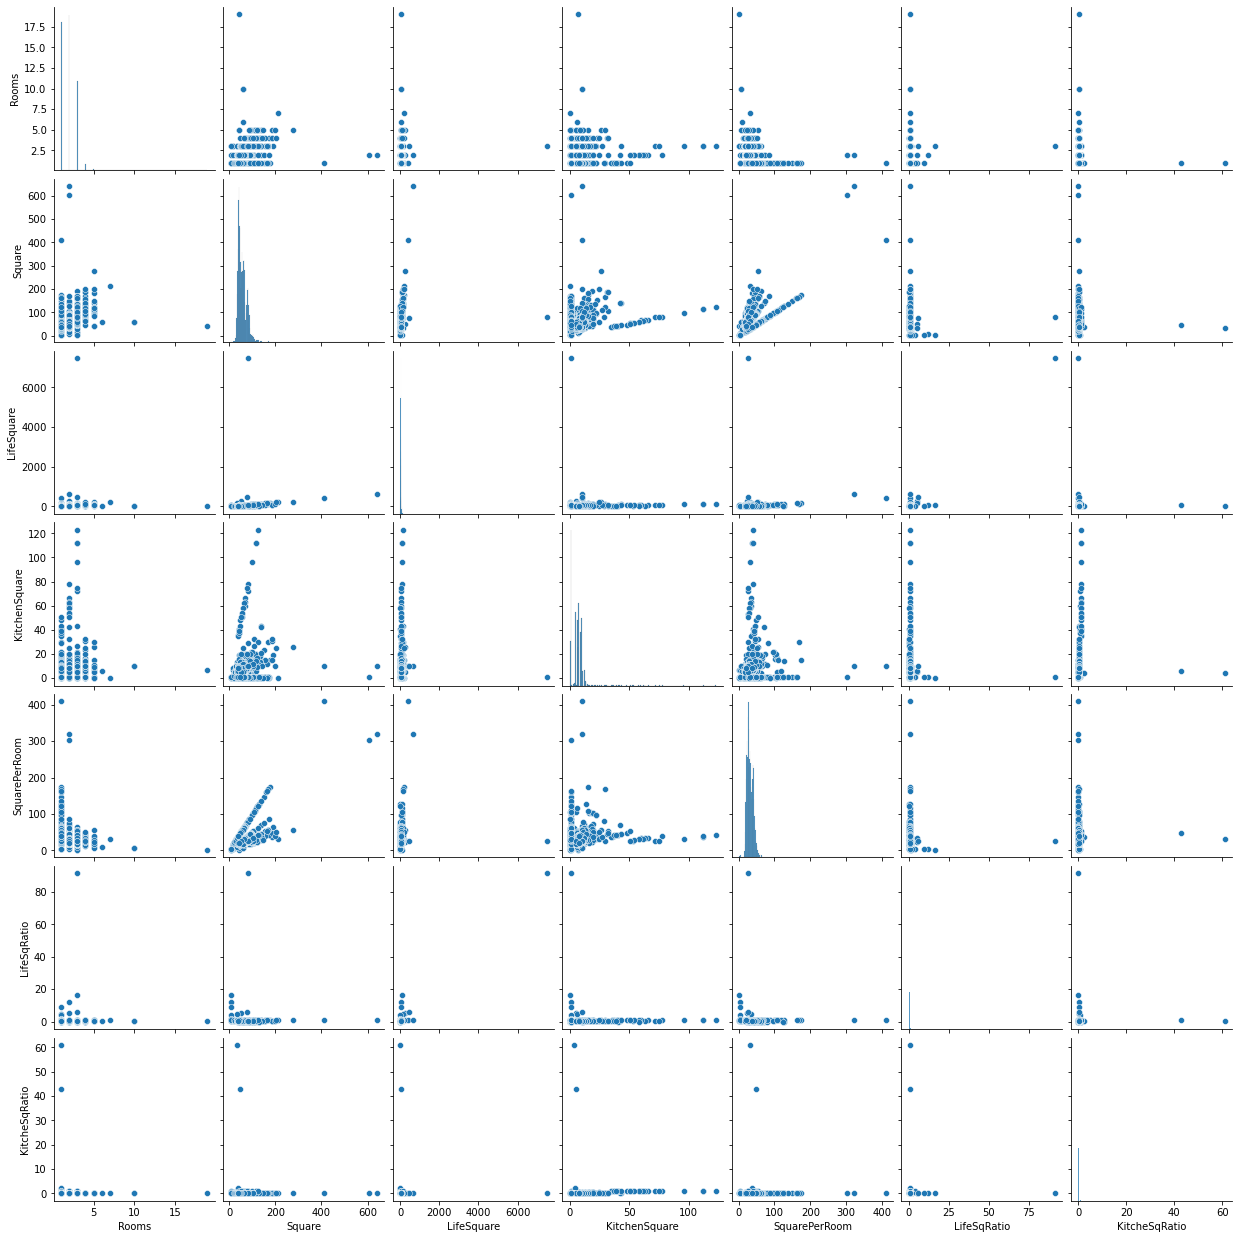

In [89]:
sns.pairplot(df_train[square_feats])

In [87]:
df_train.loc[(df_train['Rooms'] > 5) & (df_train['SquarePerRoom'] < 30), square_feats]

,Rooms,Square,LifeSquare,KitchenSquare,SquarePerRoom,LifeSqRatio,KitcheSqRatio
Id,,,,,,,
5927,10.0,59.056976,36.223072,10.0,5.905698,0.613358,0.169328
8491,19.0,42.006046,21.779287,7.0,2.210845,0.518480,0.166643
14003,6.0,59.414333,38.702244,6.0,9.902389,0.651396,0.100986
14865,10.0,60.871265,38.420681,10.0,6.087127,0.631179,0.164281


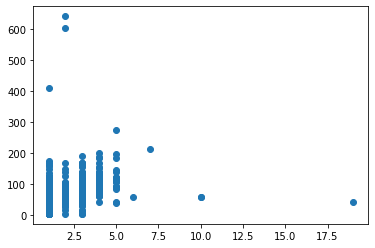

In [90]:
plt.scatter(df_train['Rooms'], df_train['Square'])

In [91]:
df_train.loc[(df_train['Rooms'] > 5) & (df_train['SquarePerRoom'] < 30), 'Rooms'] =\
            (df_train.loc[(df_train['Rooms'] > 5) & (df_train['SquarePerRoom'] < 30), 'Square'] // room_sq_med) + 1

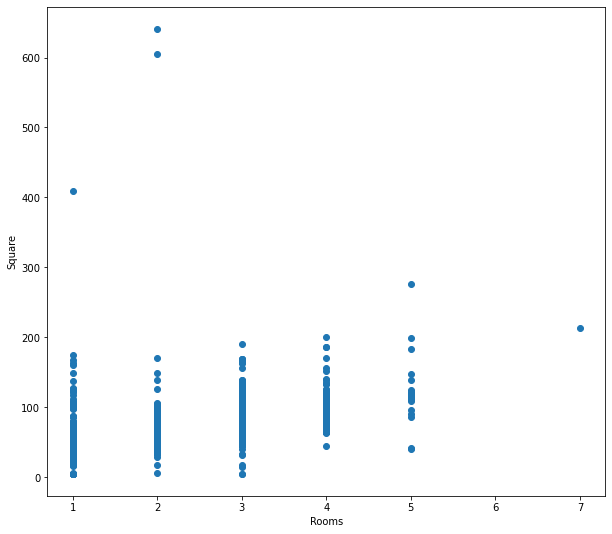

In [144]:
plt.figure(figsize=(10, 9))
plt.scatter(df_train['Rooms'], df_train['Square'])
plt.xlabel('Rooms')
plt.ylabel('Square')
plt.show()

In [148]:
df_train['SquarePerRoom'] = df_train['Square'] / df_train['Rooms']

In [149]:
df_train.loc[df_train['SquarePerRoom'] < 5, square_feats]

,Rooms,Square,LifeSquare,KitchenSquare,SquarePerRoom,LifeSqRatio,KitcheSqRatio
Id,,,,,,,
1748,2.0,5.497061,67.628716,1.0,2.748531,12.302704,0.181915
12676,3.0,13.784864,15.988890,7.0,4.594955,1.159887,0.507803
4504,3.0,5.000000,5.610772,1.0,1.666667,1.122154,0.227773
13265,3.0,5.000000,79.767967,0.0,1.666667,15.953593,0.000000


### LifeSquare

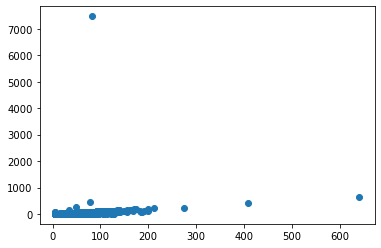

In [101]:
plt.scatter(df_train['Square'], df_train['LifeSquare']);

In [108]:
life_sq_med = df_train.loc[df_train['LifeSqRatio'] < 1, 'LifeSqRatio'].median()
life_sq_med

0.6105958819389343

In [122]:
df_train.loc[df_train['LifeSquare'] > 700, 'LifeSquare'] = df_train.loc[df_train['LifeSquare'] > 700, 'Square'] * life_sq_med

In [123]:
df_train['LifeSqRatio'] = df_train['LifeSquare'] / df_train['Square']

In [124]:
df_train.loc[df_train['LifeSqRatio'] > 1, square_feats]

,Rooms,Square,LifeSquare,KitchenSquare,SquarePerRoom,LifeSqRatio,KitcheSqRatio
Id,,,,,,,
8054,1.0,42.530045,43.967758,1.0,42.530045,1.033805,0.023513
10521,3.0,104.211395,106.340401,0.0,34.737133,1.020430,0.000000
2301,2.0,61.400055,65.224602,0.0,30.700027,1.062289,0.000000
8753,3.0,85.952309,89.803749,1.0,28.650770,1.044809,0.011634
9870,1.0,51.831474,53.491302,1.0,51.831474,1.032024,0.019293
...,...,...,...,...,...,...,...
41,2.0,59.015896,59.439083,12.0,29.507948,1.007171,0.203335
12918,2.0,51.440464,53.134243,51.0,25.720232,1.032927,0.991437
2737,3.0,123.430069,125.806984,123.0,41.143356,1.019257,0.996516


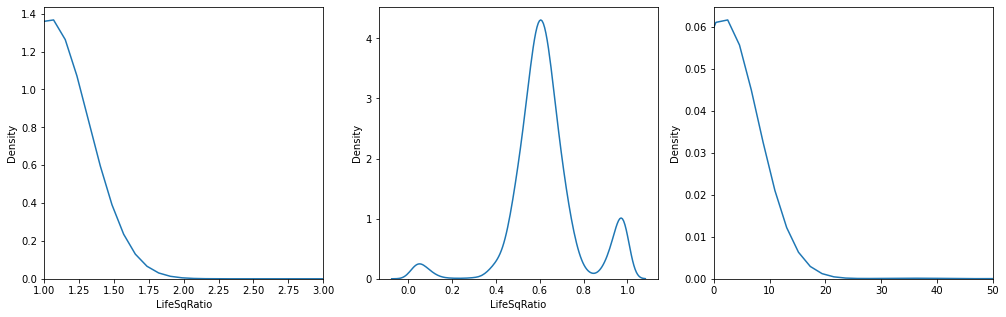

In [131]:
plt.figure(figsize=(17, 5))

plt.subplot(131)
sns.kdeplot(df_train.loc[df_train['LifeSqRatio'] > 1, 'LifeSqRatio'])
plt.xlim(1, 3)

plt.subplot(132)
sns.kdeplot(df_train.loc[df_train['LifeSqRatio'] < 1, 'LifeSqRatio'])

plt.subplot(133)
sns.kdeplot(df_train.loc[df_train['LifeSqRatio'] > 1, 'LifeSquare'] - df_train.loc[df_train['LifeSqRatio'] > 1, 'Square'])
plt.xlim(0, 50)
plt.show()

In [136]:
df_train.loc[(df_train['LifeSqRatio'] > 2) , square_feats]

,Rooms,Square,LifeSquare,KitchenSquare,SquarePerRoom,LifeSqRatio,KitcheSqRatio
Id,,,,,,,
1748,2.0,5.497061,67.628716,1.0,2.748531,12.302704,0.181915
14990,2.0,48.449875,263.542023,5.0,24.224937,5.439478,0.103199
10527,1.0,5.000000,40.805836,1.0,5.000000,8.161167,0.228273
8961,1.0,33.398983,164.153366,6.0,33.398983,4.914921,0.179646
13265,3.0,5.000000,79.767967,0.0,1.666667,15.953593,0.000000
15886,3.0,78.059334,461.463623,10.0,26.019777,5.911703,0.128108


In [137]:
life_sq_thld = 1.2

In [151]:
df_train.loc[df_train['LifeSqRatio'] > life_sq_thld, 'LifeSquare'] =\
                            df_train.loc[df_train['LifeSqRatio'] > life_sq_thld, 'Square'] * life_sq_med

In [156]:
must_be_square = df_train.loc[(df_train['LifeSqRatio'] < life_sq_thld) & (df_train['LifeSqRatio'] > 1), 'LifeSquare']
df_train.loc[(df_train['LifeSqRatio'] < life_sq_thld) & (df_train['LifeSqRatio'] > 1), 'LifeSquare'] =\
            df_train.loc[(df_train['LifeSqRatio'] < life_sq_thld) & (df_train['LifeSqRatio'] > 1), 'Square']
df_train.loc[(df_train['LifeSqRatio'] < life_sq_thld) & (df_train['LifeSqRatio'] > 1), 'Square'] = must_be_square

In [157]:
df_train.loc[(df_train['LifeSqRatio'] < life_sq_thld) & (df_train['LifeSqRatio'] > 1), square_feats]

,Rooms,Square,LifeSquare,KitchenSquare,SquarePerRoom,LifeSqRatio,KitcheSqRatio
Id,,,,,,,
8054,1.0,43.967758,42.530045,1.0,42.530045,1.033805,0.023513
10521,3.0,106.340401,104.211395,0.0,34.737133,1.020430,0.000000
2301,2.0,65.224602,61.400055,0.0,30.700027,1.062289,0.000000
8753,3.0,89.803749,85.952309,1.0,28.650770,1.044809,0.011634
9870,1.0,53.491302,51.831474,1.0,51.831474,1.032024,0.019293
...,...,...,...,...,...,...,...
41,2.0,59.439083,59.015896,12.0,29.507948,1.007171,0.203335
12918,2.0,53.134243,51.440464,51.0,25.720232,1.032927,0.991437
2737,3.0,125.806984,123.430069,123.0,41.143356,1.019257,0.996516


In [158]:
df_train['LifeSqRatio'] = df_train['LifeSquare'] / df_train['Square']

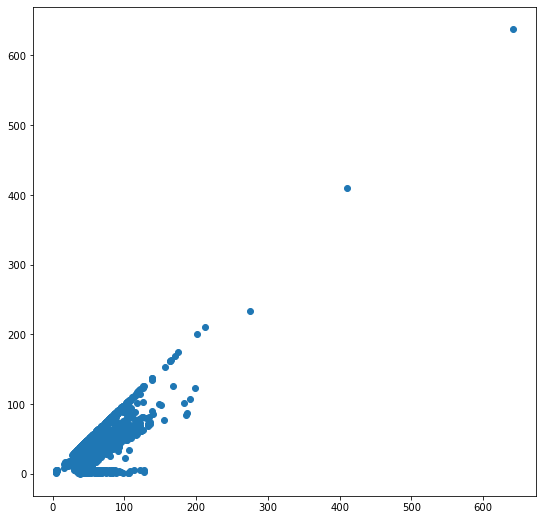

In [160]:
plt.figure(figsize=(9, 9))
plt.scatter(df_train['Square'], df_train['LifeSquare'])
plt.show()

In [162]:
life_sq_med = df_train['LifeSqRatio'].median()

In [166]:
df_train.loc[df_train['LifeSquare'].isna(), 'LifeSquare'] = df_train.loc[df_train['LifeSquare'].isna(), 'Square'] * life_sq_med

In [169]:
df_train['LifeSqRatio'] = df_train['LifeSquare'] / df_train['Square']

In [170]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     10000 non-null  float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  float32 
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   5202 non-null   float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-nul

In [171]:
df_train.drop(columns='Healthcare_1', inplace=True)

In [172]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,FloorPos,SquarePerRoom,LifeSqRatio,KitcheSqRatio
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.889300,56.393982,36.295071,5.861079,7.943200,13.435700,1984.872600,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,0.606983,32.500366,0.637915,0.123297
std,43.587592,0.813468,21.070023,18.381601,5.070414,5.228094,6.094035,18.416734,0.119026,17.532614,4006.799803,23.831875,1.493601,4.806341,0.284851,11.393231,0.157509,0.749377
min,0.000000,1.000000,5.000000,0.370619,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.035714,1.666667,0.006001,0.000000
25%,20.000000,1.000000,41.863287,24.219816,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,0.352941,25.590845,0.574933,0.022591
50%,36.000000,2.000000,52.592594,33.241903,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,0.642857,30.808279,0.617326,0.120688
75%,75.000000,2.000000,65.985905,44.771268,9.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,0.875000,38.990761,0.667654,0.165121
max,209.000000,7.000000,641.065186,638.163208,123.000000,42.000000,117.000000,2021.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,409.425171,0.999949,61.034805


In [174]:
df_train = pd.get_dummies(df_train)

In [175]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int16  
 1   Rooms          10000 non-null  float32
 2   Square         10000 non-null  float32
 3   LifeSquare     10000 non-null  float32
 4   KitchenSquare  10000 non-null  float32
 5   Floor          10000 non-null  float32
 6   HouseFloor     10000 non-null  float32
 7   HouseYear      10000 non-null  int32  
 8   Ecology_1      10000 non-null  float32
 9   Social_1       10000 non-null  int8   
 10  Social_2       10000 non-null  int16  
 11  Social_3       10000 non-null  int16  
 12  Helthcare_2    10000 non-null  int8   
 13  Shops_1        10000 non-null  int8   
 14  FloorPos       10000 non-null  float32
 15  SquarePerRoom  10000 non-null  float32
 16  LifeSqRatio    10000 non-null  float32
 17  KitcheSqRatio  10000 non-null  float32
 18  Eco

In [176]:
df_train.DistrictId.unique()

array([ 35,  41,  53,  58,  99,  59, 154,  74,   1,  23,  28,  31,  13,
        57,  27,  85,  34,  19,   0,  48,  54, 150,  11,  50,  61,  44,
        90, 200,  43, 177, 101,  38,  21, 103,  98, 170,  94,   5,  88,
        47,   6,  52,  62,  77,  79,   9, 156,  69, 108,  96, 169,  18,
       148, 128,  10, 144, 120,  39,   7,  84, 123, 159,  70, 129,   3,
        95,  78,  45,  15, 121,  49,  25,   2, 127,  56, 109,  46,  17,
       119,  80,  86,  83, 137,  91,  92, 118, 187,  36, 106, 161,  22,
        63, 167, 113,  66,  29,  37,  20,   8, 181,  40,  93,  30,  81,
       107, 130, 100,  12, 125,  67,  26,  89,  24, 111, 138,  64, 124,
       183,  55, 157, 151,  33,  87, 126, 155, 164, 105, 110, 132,  71,
        73, 189,  75, 122, 163, 141,  76, 115, 139, 143, 201, 165, 190,
       193, 174,  60, 114, 172, 134, 117, 149, 153, 131, 145,  82, 160,
        42,  32, 133, 208, 171, 176, 173, 147,  97, 142, 195, 180, 196,
       112,  72, 175,   4, 186, 146, 191, 168, 192,  14, 199, 13

In [179]:
dist = df_train['DistrictId'].value_counts()
dist

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
205      1
174      1
209      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [182]:
dist = dist[dist > 50]
dist = dict(dist)

In [183]:
df_train['DistrictId'].map(dist)

Id
14038      NaN
15053     87.0
4765     174.0
5809     179.0
10783     97.0
         ...  
77         NaN
6159      51.0
5123     851.0
5400      66.0
6306      64.0
Name: DistrictId, Length: 10000, dtype: float64

In [184]:
?pd.DataFrame.fillna